<a href="https://colab.research.google.com/github/tanvigunjal/Computer_Vision/blob/main/Convolution_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Convolutional Network

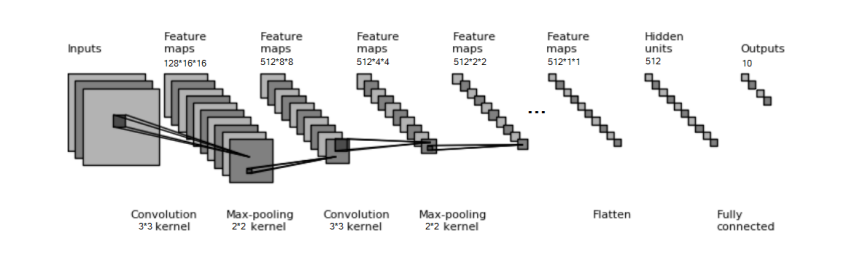

It has five convolution blocks. Each block is consist of convolution, max pooling and ReLU operation in that order. We will use 3×3 kernels in all convolutional layers. Set the padding and stride of the convolutional layers so that they maintain the spatial dimensions. Max pooling operations are done with 2×2 kernels, with a stride of 2, thereby halving the spatial resolution each time. Finally, five stacking these five blocks leads to a 512 × 1 × 1 feature map. Classification is achieved by a fully connected layer. We will train convolutional neural networks on CIFAR-10 dataset. The ConvNet takes 32 ×32 color images as inputs and has 5 hidden layers with 128, 512, 512, 512, 512 filters, and produces 10-class classification. 


In [ ]:

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt

Using device: cuda
[128, 512, 512, 512, 512, 512]
Files already downloaded and verified
Files already downloaded and verified
ConvNet(
  (layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1,

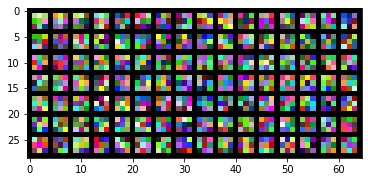

Epoch [1/30], Step [100/383], Loss: 1.4608
Epoch [1/30], Step [200/383], Loss: 1.3937
Epoch [1/30], Step [300/383], Loss: 1.2051
Training accuracy is: 74.03846153846153 %
Validataion accuracy is: 58.9 %
Best Model Changed 0.0 0.589
Epoch [2/30], Step [100/383], Loss: 1.0526
Epoch [2/30], Step [200/383], Loss: 1.3057
Epoch [2/30], Step [300/383], Loss: 0.9846
Training accuracy is: 79.8076923076923 %
Validataion accuracy is: 63.0 %
Best Model Changed 0.589 0.63
Epoch [3/30], Step [100/383], Loss: 0.8144
Epoch [3/30], Step [200/383], Loss: 0.8851
Epoch [3/30], Step [300/383], Loss: 1.0362
Training accuracy is: 75.0 %
Validataion accuracy is: 69.5 %
Best Model Changed 0.63 0.695
Epoch [4/30], Step [100/383], Loss: 0.7309
Epoch [4/30], Step [200/383], Loss: 0.8488
Epoch [4/30], Step [300/383], Loss: 0.9592
Training accuracy is: 74.03846153846153 %
Validataion accuracy is: 72.6 %
Best Model Changed 0.695 0.726
Epoch [5/30], Step [100/383], Loss: 0.9128
Epoch [5/30], Step [200/383], Loss: 0.7

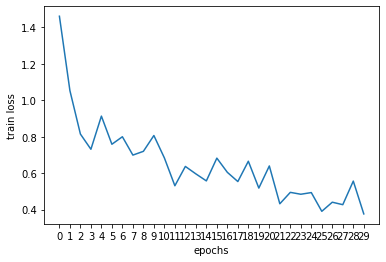

Accuracy of the network on the 10000 test images: 86.94 %


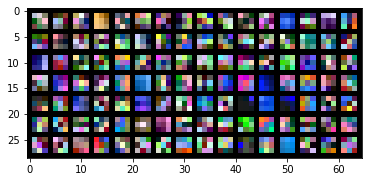

In [ ]:
# -*- coding: utf-8 -*-
"""ex3_convnet.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/12ClW6nf7Y33WTNzPmQoo0aALHqa5zyUP
"""


def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 3
num_classes = 10
hidden_size = [128, 512, 512, 512, 512, 512]
num_epochs = 30
batch_size = 128
learning_rate = 2e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
norm_layer = None
print(hidden_size)


#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
#################################################################################
# Chosse the right data augmentation transforms with the right                  #
# hyper-parameters and put them in the data_aug_transforms variable             #
#################################################################################
data_aug_transforms = []

data_aug_transforms = [
                                          transforms.ColorJitter(brightness=0.5),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.RandomVerticalFlip(p=0.05),
                                          transforms.RandomGrayscale(p=0.2),

]


norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
# norm_transform = data_aug_transforms
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='/content/drive/My Drive/',
                                           train=True,
                                           transform=norm_transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/My Drive/',
                                          train=False,
                                          transform=test_transform,
                                          download=True
                                          )
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

cifar_dataset

#-------------------------------------------------
# Convolutional neural network 
# Set norm_layer for different networks whether using batch normalization
#-------------------------------------------------
class ConvNet(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, norm_layer=None):
        super(ConvNet, self).__init__()
        #################################################################################
        # Initialize the modules required to implement the convolutional layer  #
        #                                                                       #
        #  make use of conv2d and relu layers from the torch.nn module.         #
        #  make use of BatchNorm2d layer from the torch.nn module.              #
        #  Use Dropout layer from the torch.nn module.                          #
        #################################################################################
        layers = []
         
        for i,each in enumerate(hidden_layers):
              if(i!=5):
                if(i==0):
                  layers.append(nn.Conv2d(input_size,each,3,padding=1))
                else:
                  layers.append(nn.Conv2d(hidden_layers[i-1],each,3,padding=1))
                layers.append(nn.MaxPool2d(2,2))
                layers.append(nn.ReLU())
                layers.append(nn.BatchNorm2d(each))
                layers.append(nn.Dropout(0.2))
              else:
                layers.append(nn.Flatten())
                layers.append(nn.Linear(each,num_classes))

        self.layers = nn.Sequential(*layers)


    def forward(self, x):
        # Implement the forward pass computations       
        out = self.layers(x)
        return out
#-------------------------------------------------
# Calculate the model size 
# if disp is true, print the model parameters, otherwise, only return the number of parameters.
#-------------------------------------------------
def PrintModelSize(model, disp=True):
    #################################################################################
    # Implement the function to count the number of trainable parameters in         #
    # the input model. This useful to track the capacity of the model you are       #
    # training                                                                      #
    #################################################################################
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Total Trainable Params:',trainable_params)
    return trainable_params

#-------------------------------------------------
# Calculate the model size 
# visualize the convolution filters of the first convolution layer of the input model
#-------------------------------------------------
def VisualizeFilter(model):
    #################################################################################
    # Implement the functiont to visualize the weights in the first conv layer      #
    # in the model. Visualize them as a single image fo stacked filters.            #
    # You can use matlplotlib.imshow to visualize an image in python                #
    #################################################################################
    orient = (2,1,0)
    first_layer_weights = model.layers[0].weight
    np_weights = first_layer_weights.clone().detach().data.cpu().numpy()

    pad = 1
    columns = 16
    padding_mat_x = np.zeros((3, pad, 3))
    padding_mat_y = np.zeros((pad, (3+pad)*columns+pad, 3))

    row = padding_mat_x
    full_img = padding_mat_y
    for kernel_i in range(0, np_weights.shape[0]):
        if(kernel_i % columns == 0 and kernel_i != 0):
            full_img = np.concatenate((full_img,  row), axis=0)
            full_img = np.concatenate(
                (full_img, padding_mat_y), axis=0)
            row = padding_mat_x

        if orient is not None:
            filter_ = np.transpose(np_weights[kernel_i], orient)
        else:
            filter_ = np_weights[kernel_i]

        filter_ = (filter_ - filter_ .min()) / \
            (filter_.max() - filter_ .min())
        row = np.concatenate(
            (row, filter_), axis=1)
        row = np.concatenate((row,  padding_mat_x), axis=1)

    plt.imshow(full_img)
    plt.show()


model = ConvNet(input_size, hidden_size, num_classes, norm_layer=norm_layer).to(device)
model.apply(weights_init)
# Print the model
print(model)
# Print model size
#======================================================================================
#  count the number of trainable parameters in the model
#======================================================================================
PrintModelSize(model)
#======================================================================================
# visualize the filters in the first conv layers.
# Visualize the filters before training
#======================================================================================
VisualizeFilter(model)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
val_accuracy = 0.
best_model = None

def print_loss_curve(loss_res):
    samples_per_epoch = (int)((num_training/batch_size)/100)
    indieces = list(filter(lambda x: x %
                           samples_per_epoch == 0, range(0, len(loss_res))))
    final_samples = (np.asarray(loss_res)[indieces])
    x = range(0, len(final_samples))
    plt.plot(x, final_samples)
    plt.xticks(x)
    plt.ylabel("train loss")
    plt.xlabel("epochs")
    plt.show()

loss_res = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            loss_res.append(loss.item())

    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        ##For Calculating Training Accuracy
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print('Training accuracy is: {} %'.format(100 * correct / total))
        correct,total = 0,0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Validataion accuracy is: {} %'.format(100 * correct / total))
        #################################################################################
        # Implement the early stopping mechanism to save the model which has            #
        # acheieved the best validation accuracy so-far.                                #
        #################################################################################
        if((correct/total)>val_accuracy):
          print('Best Model Changed',val_accuracy,correct/total)
          best_model = model
          val_accuracy = (correct/total)

    model.train()
print_loss_curve(loss_res)

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()
#################################################################################
# Implement the early stopping mechanism to load the weights from the#
# best model so far and perform testing with this model.                        #
#################################################################################

model = best_model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

# Implementing the function to visualize the filters in the first conv layers.
# Visualize the filters before training
VisualizeFilter(model)
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')


# Transfer learning from a ImageNet pretrained model

We will use the VGG_11_bn network from the torchvision.models library as our backbone network. This model has been trained on ImageNet achieving top-5 error rate of 10.19%. It consists of 8 convolutional layers followed by adaptive average pooling and fully-connected layers to perform the classification. We will get rid of the average pooling and fully-connected layers from the VGG_11_bn model and attach our own fully connected layers to perform the Cifar-10 classifcation.

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torchvision.transforms as transforms

def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 32 * 32 * 3
layer_config= [512, 256]
num_classes = 10
num_epochs = 30
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.99
reg=0#0.001
num_training= 49000
num_validation =1000
fine_tune = False
pretrained= True

data_aug_transforms = [transforms.RandomHorizontalFlip(p=0.5)]#, transforms.RandomGrayscale(p=0.05)]
#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
# Q1,
norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                          train=False,
                                          transform=norm_transform,
                                           download=True
                                          )
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

class VggModel(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(VggModel, self).__init__()
        #################################################################################
        # TODO: Build the classification network described in Q4 using the              #
        # models.vgg11_bn network from torchvision model zoo as the feature extraction  #
        # layers and two linear layers on top for classification. You can load the      #
        # pretrained ImageNet weights based on the pretrained flag. You can enable and  #
        # disable training the feature extraction layers based on the fine_tune flag.   #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.n_class = n_class
        self.fine_tune = fine_tune
        self.pretrained = pretrained
        self.conv_layers = []
        self.fc_layers = []
        conv_layers = []
        fc_layers = []

        vgg11 = models.vgg11_bn(pretrained = self.pretrained)
        # Convolution Layers for feature extraction
        for layer in vgg11.features:
            conv_layers.append(layer)
        self.conv_layers = nn.Sequential(*conv_layers)
        set_parameter_requires_grad(self, fine_tune)
        # fully connected layers
        # shape of the output from last conv layer is bs x 512 x 1 x 1
        fc_layers.append( nn.Linear(512, layer_config[0]))
        fc_layers.append( nn.BatchNorm1d(layer_config[0]))
        fc_layers.append( nn.ReLU())
        fc_layers.append( nn.Linear(layer_config[0], layer_config[1]))
        fc_layers.append( nn.BatchNorm1d(layer_config[1]))
        fc_layers.append( nn.ReLU())
        fc_layers.append( nn.Linear(layer_config[1], num_classes))

        self.fc_layers = nn.Sequential(*fc_layers)
        if(not pretrained):
            self.apply(weights_init)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        conv_layers = self.conv_layers
        x = conv_layers(x)
        fc_layers = self.fc_layers
        x = x.view(batch_size, 512)
        x = fc_layers(x)
        out = x
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

# Initialize the model for this run
model= VggModel(num_classes, fine_tune, pretrained)
# Print the model we just instantiated
print(model)

#################################################################################
# TODO: Only select the required parameters to pass to the optimizer. No need to#
# update parameters which should be held fixed (conv layers).                   #
#################################################################################
print("Params to learn:")
if fine_tune:
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # TODO make this work
    params_to_update = model.fc_layers.parameters()
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
else:
    params_to_update = model.parameters()
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
best_model_path = './best_model.ckpt'
best_acc= 0
train_losses = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        train_losses.append(loss.item())
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        #################################################################################
        # TODO: Q2.b Use the early stopping mechanism from previous questions to save   #
        # the model which has acheieved the best validation accuracy so-far.            #
        #################################################################################
        best_model = None
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        acc = 1.0 * correct / total
        if(best_acc < acc):
            best_acc = acc
            best_model = model
            torch.save(model.state_dict(), best_model_path)
            print("Updated best model")
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        print('Validataion accuracy is: {} %'.format(100 * correct / total))

#################################################################################
# TODO: Use the early stopping mechanism from previous question to load the     #
# weights from the best model so far and perform testing with this model.       #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model.load_state_dict(torch.load(best_model_path))
model.eval()
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')
# Save the training loss for plots
# with open('train_losses.csv', 'w') as f:
#     for item in train_losses:
#         f.write("{},\n".format(item))


Using device: cuda


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets/
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VggModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxP